# 1. detect people

In [ ]:
# based on: https://www.youtube.com/watch?v=Pb3opEFP94U&t=813s
# based on: https://colab.research.google.com/drive/1x-eMvFQTLBTr7ho9ZlYkHF0NmyUyAlxT?usp=sharing#scrollTo=Z_pe5XFayoHP

### import libraries

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2 import model_zoo
from detectron2.structures import Boxes
from detectron2.structures import Keypoints
from PIL import Image
from SVM import *

import detectron2
import cv2 as cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import timeit
import pandas as pd
import random as rnd

### configure detector

In [ ]:
def __init__(mode):
    """
    Method initializing a detector with a config file

    :param: mode: Select work mode (Object Detection, Keypoint Extraction)

    :return predictor and cfg objects
    """

    if mode == "OD":
        cfg_od = get_cfg()
        cfg_od.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
        cfg_od.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

        cfg_od.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        cfg_od.MODEL.DEVICE = "cpu"
        predictor_od = DefaultPredictor(cfg_od)

        return predictor_od, cfg_od

    elif mode == "KP":
        cfg_kp = get_cfg()
        cfg_kp.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
        cfg_kp.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

        cfg_kp.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
        cfg_kp.MODEL.DEVICE = "cpu"
        predictor_kp = DefaultPredictor(cfg_kp)

        return predictor_kp, cfg_kp

predictor_od, cfg_od = __init__(mode="OD")

### define function responsible for detected class reduction to one

In [ ]:
def chooseOneClassFromAllDetected(initialPredictions, image):
    """
    Method responsible for reducing detected object classes to one particular

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: image to be processed
    """

    classes = initialPredictions["instances"].pred_classes
    scores = initialPredictions["instances"].scores
    boxes = initialPredictions["instances"].pred_boxes

    index_to_keep = (classes == 0).nonzero().flatten().tolist()

    classes_filtered = torch.tensor(np.take(classes.cpu().numpy(), index_to_keep))
    scores_filtered = torch.tensor(np.take(scores.cpu().numpy(), index_to_keep))
    boxes_filtered = Boxes(
        torch.tensor(np.take(boxes.tensor.cpu().numpy(), index_to_keep, axis=0))
    )

    obj = detectron2.structures.Instances(
        image_size=(image.shape[0], image.shape[1])
    )
    obj.set("pred_classes", classes_filtered)
    obj.set("scores", scores_filtered)
    obj.set("pred_boxes", boxes_filtered)

    return obj

### load an image

In [ ]:
def loadImage(imagePath, changeColorMode=True):
    """
    Method responsible for loading an image

    :param: imagePath: path to the image
    :param: changeColorMode: change BGR to RGB, useful when using both cv2 and matplotlib

    :return image object
    """

    image = cv2.imread(imagePath)
    if changeColorMode == True:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

image = loadImage(imagePath="images/cross_walk_she.png", changeColorMode=True)

### perform detection and make prediction boxes

In [ ]:
def performDetection(predictor, image, classReduction):
    """
    Method performing actual detection

    :param: predictor: predictor object
    :param: image: image object
    :param: classReduction: enables class reduction to one


    :return prediction, (optionally) new_predictions and prediction boxes objects
    """

    predictions = predictor(image)

    if classReduction == True:
        new_predictions = chooseOneClassFromAllDetected(initialPredictions=predictions, image=image)
        prediction_boxes = [x.numpy() for x in list(new_predictions.pred_boxes)]

        return predictions, new_predictions, prediction_boxes

    elif classReduction == False:

        return predictions

predictions_od, new_predictions_od, prediction_od_boxes = performDetection(predictor=predictor_od, image=image, classReduction=True)

### make visualization part and extract image with boxes

In [ ]:
viz_od = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_od = viz_od.draw_instance_predictions(new_predictions_od.to("cpu"))

image_with_boxes = output_od.get_image()[:, :, ::-1]

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_with_boxes)
plt.tight_layout()

# 2. cut part of the image from bounding boxes

In [ ]:
# based on: https://stackoverflow.com/questions/68008935/crop-image-using-pred-boxes-coordinates

### define function responsible for cropping part of an image defined by bounding box coordinates

In [ ]:
def cropImageByBoundingBox(image, box):
    """
    Function responsible for cropping part of an image defined by bounding box coordinates

    :param: image: image to be processed
    :param: box: numpy array with four box coordinates

    return: cropped image object
    """

    x_top_left = box[0]
    y_top_left = box[1]
    x_bottom_right = box[2]
    y_bottom_right = box[3]

    if type(image) == np.ndarray:
        image = Image.fromarray(image)
    crop_img = image.crop((int(x_top_left), int(y_top_left), int(x_bottom_right), int(y_bottom_right)))

    if type(image) == Image.Image:
        crop_img = np.array(crop_img)

    return crop_img, (x_top_left, y_top_left)

### perform exemplary cropping

In [ ]:
image_index = 0
image_cropped, cropped_image_coordinates = cropImageByBoundingBox(image, prediction_od_boxes[image_index])

fig, ax = plt.subplots(figsize=(14, 7))
ax.imshow(image_cropped)
plt.tight_layout()

# 3. make individual skeletonization for each cropped image

### configure another detector (keypoint extraction)

In [ ]:
predictor_kp, cfg_kp = __init__(mode="KP")

### make predictions

In [ ]:
predictions_kp = performDetection(predictor=predictor_kp, image=image_cropped, classReduction=False)

### define function to filter detections to take only the best one

In [ ]:
def chooseIndexOfBestKeypointInstanceFromAllDetected(predictions):
    """
    Method responsible for choosing the best (the longest in the sense of euclidean distance) detection instance

    :param: predictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)

    return index of the best (the longest in the sense of euclidean distance) prediction
    """

    # index = np.array([predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(len(predictions["instances"].pred_keypoints.numpy()))])

    length = len(predictions["instances"].pred_keypoints.numpy())
    [predictions["instances"][i].pred_keypoints.numpy().sum() for i in range(length)]

    initial_predictions_all = predictions["instances"].pred_keypoints.numpy()
    index = np.array([])

    for prediction in initial_predictions_all:
        sum = 0
        for i in range(len(prediction)-1):
            sum += np.linalg.norm(prediction[i] - prediction[i+1])
        index = np.append(index, sum)

    if len(index) > 0:
        index_of_value_to_keep = np.argmax(index)
    else:
        index_of_value_to_keep = 0

    return int(index_of_value_to_keep)

### visualize results

In [ ]:
viz_kp = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image_cropped[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]
image_skeletonized_dots = output_kp_dots.get_image()[:, :, ::-1]

fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(image_skeletonized)
ax[1].imshow(image_skeletonized_dots)
plt.tight_layout()

In [ ]:
# it seems that detecting people and making skeletons on a scene image (the initial one) gives better accuracy skeletonization
# compared to detecting people and making skeletonization on individual people

# 4. project individual masks on the initial picture

### projecion without coordinates correction

In [ ]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
if index == 0:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

### projecion with coordinates correction

In [ ]:
def correctIndividualSkeletonCoordinates(initialPredictions, image, croppedImageCoordinates):
    """
    Method responsible for correction of individual detection (box, keypoints) coordinates to match initial picture position

    :param: initialPredictions: predictions produced by self.predictor which is DefaultPredictor(self.cfg)
    :param: image: cropped image
    :param: croppedImageCoordinates: cooridnates of the cropped image on the initiial one

    return corrected predictions (box, keypoints)
    """

    boxes = initialPredictions["instances"].pred_boxes
    boxes_filtered = boxes.tensor.cpu().numpy().copy()
    boxes_filtered[:,0] += croppedImageCoordinates[0]
    boxes_filtered[:,2] += croppedImageCoordinates[0]
    boxes_filtered[:,1] += croppedImageCoordinates[1]
    boxes_filtered[:,3] += croppedImageCoordinates[1]

    keypoints = initialPredictions["instances"].pred_keypoints
    keypoints_filtered = keypoints.cpu().numpy().copy()
    keypoints_filtered[:,:,0] += croppedImageCoordinates[0]
    keypoints_filtered[:,:,1] += croppedImageCoordinates[1]

    scores = initialPredictions["instances"].scores

    boxes_filtered = Boxes(torch.tensor(boxes_filtered))
    keypoints_filtered = torch.tensor(keypoints_filtered)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_filtered)
    obj.set("pred_keypoints", keypoints_filtered)
    obj.set("scores", scores)

    return obj

In [ ]:
new_preds = correctIndividualSkeletonCoordinates(initialPredictions=predictions_kp, image=image_cropped, croppedImageCoordinates=cropped_image_coordinates)

In [ ]:
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)

if index == 0:
    output_kp = viz_kp.draw_instance_predictions(new_preds.to("cpu"))
else:
    output_kp = viz_kp.draw_instance_predictions(new_preds[index].to("cpu"))
image_skeletonized = output_kp.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_skeletonized)
plt.tight_layout()

In [ ]:
def combineAllPredictionsTogether(predictionsDict):
    """
    Method responsible for combining all predictions from individual images into one

    :param: predictionsDict: dictionary with predictions for each image

    return one combined prediction instance object
    """

    number_of_people = len(predictionsDict.keys())
    pred_sum = predictionsDict[0]
    boxes_sum = pred_sum.pred_boxes.tensor.cpu().numpy().copy()
    keypoints_sum = pred_sum.pred_keypoints.cpu().numpy().copy()
    scores_sum = pred_sum.scores.cpu().numpy().copy()

    if number_of_people > 1:
        for i in range(1, number_of_people-1):
            pred = predictionsDict[i]
            boxes = pred.pred_boxes.tensor.cpu().numpy().copy()
            keypoints = pred.pred_keypoints.cpu().numpy().copy()
            scores = pred.scores.cpu().numpy().copy()

            boxes_sum = np.vstack([boxes_sum, boxes])
            keypoints_sum = np.vstack([keypoints_sum, keypoints])
            scores_sum = np.append(scores_sum, scores)

    boxes_sum = Boxes(torch.tensor(boxes_sum))
    keypoints_sum = torch.tensor(keypoints_sum)

    obj = detectron2.structures.Instances(image_size=(image.shape[0], image.shape[1]))
    obj.set("pred_boxes", boxes_sum)
    obj.set("pred_keypoints", keypoints_sum)
    obj.set("scores", scores_sum)

    return obj

# put steps 1-4 together

In [ ]:
start_time = timeit.default_timer()

# prepare detectors
## initialize OD detector
predictor_od, cfg_od = __init__(mode="OD")

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

# 0. load an image
imagePath = "images/Pedestrian-Deaths-India-Road-Fatalities-India-1280x720.jpeg"
image = loadImage(imagePath=imagePath, changeColorMode=True)

# 1. perform detection and make prediction boxes
(
    predictions_od,
    reduced_predictions_od,
    prediction_od_boxes,
) = performDetection(
    predictor=predictor_od, image=image, classReduction=True
)
## make visualization part
viz_od = Visualizer(
    image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]),
    instance_mode=ColorMode.IMAGE,
)
output_od = viz_od.draw_instance_predictions(reduced_predictions_od.to("cpu"))
image_with_boxes = output_od.get_image()[:, :, ::-1]

number_of_people = len(reduced_predictions_od)
predictions_kp_all = {}
images_kp_all = {}
image_final = image.copy()

for person_index in range(number_of_people):
    # 2. cut part of the image from bounding boxes
    image_cropped, cropped_image_coordinates = cropImageByBoundingBox(
        image=image, box=prediction_od_boxes[person_index]
    )

    # 3. make individual skeletonization for the cropped image
    ## perform detection
    predictions_kp = performDetection(
        predictor=predictor_kp, image=image_cropped, classReduction=False
    )
    ## make visualization part
    viz_kp = Visualizer(
        image_cropped[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]

    # 4. project individual mask on the initial picture
    corrected_predictions = correctIndividualSkeletonCoordinates(
        initialPredictions=predictions_kp,
        image=image_cropped,
        croppedImageCoordinates=cropped_image_coordinates,
    )
    ## make visualization part
    viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions.to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions[index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]
    ## combine all results
    if index == 0:
      predictions_kp_all[person_index] = corrected_predictions.to("cpu")
    else:
      predictions_kp_all[person_index] = corrected_predictions[index].to("cpu")

    images_kp_all[person_index] = image_skeletonized

final_predictions = combineAllPredictionsTogether(predictionsDict=predictions_kp_all)
viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
)
output_sum = viz_kp.draw_instance_predictions(final_predictions.to("cpu"))
image_sum = output_sum.get_image()[:, :, ::-1]

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_sum)
plt.tight_layout()

stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# experiment: detect people all by once and measure time

In [ ]:
## start measuring execution time
start_time = timeit.default_timer()

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

## make predictions
predictions_kp = performDetection(predictor=predictor_kp, image=image, classReduction=False)

## make visualization part
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
image_final = output_kp.get_image()[:, :, ::-1]
image_final_dots = output_kp_dots.get_image()[:, :, ::-1]

## show resulsts
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(image_final)
ax[1].imshow(image_final_dots)
plt.tight_layout()

## stop measuring execution time
stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# 5. people classification:
- ## entering the road
- ## being on the road
- ## off the interest scope (on a bike, motorcycle, etc.)

### add picture skeleton data to dataframe for classification

In [ ]:
def addPedestrianDataToDataFrame(predictions, index, classification, df=None):
    """
    Method resonsible for creating DataFrame from predictions' keypoints

    :param: predictions: predictions for the whole scene
    :param: index: index of the selected person
    :param: classification: label for the new entry ('stationary', 'in motion')
    :param: df: pandas DataFrame

    return existing df with appended new entry if df is not None and df with new entry only otherwise
    """

    keypoints_x = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,0]
    keypoints_x_normalized = keypoints_x / np.linalg.norm(keypoints_x)
    keypoints_y = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,1]
    keypoints_y_normalized = keypoints_y / np.linalg.norm(keypoints_y)
    # keypoints_score = predictions["instances"][index].pred_keypoints.to("cpu").numpy()[:,:,2]

    # keypoint_vector = np.hstack([keypoints_x_normalized, keypoints_y_normalized, keypoints_score])
    keypoint_vector = np.hstack([keypoints_x_normalized, keypoints_y_normalized])

    df_new = pd.DataFrame(keypoint_vector)
    df_new['classification'] = classification
    if df is not None:
        df = df.append(df_new)
        return df
    else:
        return df_new

### method responsible for deploying SVM One vs Other strategy

In [ ]:
def classifyOneVsOther(df_classification, df_skeleton, model, movement, vector):
    """
    Method resonsible for deploying SVM One vs Other strategy on given data

    :param: df_classification: DataFrame with classification data
    :param: df_skeleton: DataFrame with skeleton data
    :param: model: SVM model instance
    :param: movement: investigated movement i.e. go-left
    :param: vector: keypoints for intvestigated person

    return movement if classified and 'other' if not
    """

    df_classification['simplified_classification'] = np.where(df_classification['classification'] == movement, 1, -1)
    Y = np.array(df_classification['simplified_classification'])
    X = np.array(df_skeleton)
    model.performFit(X,Y)
    y_hat = model.makePrediction(vector)
    if y_hat == 1:
        return movement
    else:
        return "other"

### metohod responsible for classifying person's movement

In [ ]:
def classifyPerson(df_classification, df_skeleton, model, vector):
    """
    Method resonsible for classifying person movement i.e. ['go-left', 'go-forward']

    :param: df_classification: DataFrame with classification data
    :param: df_skeleton: DataFrame with skeleton data
    :param: model: SVM model instance
    :param: vector: keypoints for intvestigated person

    return person's classification
    """

    classificationFinal = []
    for option in ['stationary', 'go-left', 'go-right', 'go-forward', 'go-backward']:
        classificationPartial = classifyOneVsOther(df_classification, df_skeleton, model, option, vector)
        if classificationPartial != "other":
            classificationFinal.append(classificationPartial)
    return classificationFinal

### read skeleton data

In [ ]:
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

In [ ]:
df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)
# df_skeleton = df_skeleton.head(100)

### read classification data

In [ ]:
df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']
# df_classification = df_classification.head(100)

### merge both dataframes

In [ ]:
merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

In [ ]:
df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

### initialize SVM model and make predictions

In [ ]:
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'

model = SVM(max_iter,kernel_type,C,epsilon)

In [ ]:
df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=0, classification="in motion")
vector = np.array(df)[0][:34]

In [ ]:
x = classifyPerson(df_classification, df_skeleton, model, vector)
x

# put all together

In [ ]:
start_time = timeit.default_timer()

# prepare detectors
## initialize OD detector
predictor_od, cfg_od = __init__(mode="OD")

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

# 0. load an image
imagePath = "images/cross_walk_she.png"
image = loadImage(imagePath=imagePath, changeColorMode=True)

# 1. perform detection and make prediction boxes
(
    predictions_od,
    reduced_predictions_od,
    prediction_od_boxes,
) = performDetection(
    predictor=predictor_od, image=image, classReduction=True
)
## make visualization part
viz_od = Visualizer(
    image[:, :, ::-1],
    metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]),
    instance_mode=ColorMode.IMAGE,
)
output_od = viz_od.draw_instance_predictions(reduced_predictions_od.to("cpu"))
image_with_boxes = output_od.get_image()[:, :, ::-1]

number_of_people = len(reduced_predictions_od)
predictions_kp_all = {}
images_kp_all = {}
image_final = image.copy()

for person_index in range(number_of_people):
    # 2. cut part of the image from bounding boxes
    image_cropped, cropped_image_coordinates = cropImageByBoundingBox(
        image=image, box=prediction_od_boxes[person_index]
    )

    # 3. make individual skeletonization for the cropped image
    ## perform detection
    predictions_kp = performDetection(
        predictor=predictor_kp, image=image_cropped, classReduction=False
    )
    ## make visualization part
    viz_kp = Visualizer(
        image_cropped[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    index = chooseIndexOfBestKeypointInstanceFromAllDetected(predictions=predictions_kp)
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"][index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]

    # 4. project individual mask on the initial picture
    corrected_predictions = correctIndividualSkeletonCoordinates(
        initialPredictions=predictions_kp,
        image=image_cropped,
        croppedImageCoordinates=cropped_image_coordinates,
    )
    ## make visualization part
    viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
    )
    if index == 0:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions.to("cpu"))
    else:
        output_kp = viz_kp.draw_instance_predictions(corrected_predictions[index].to("cpu"))
    image_skeletonized = output_kp.get_image()[:, :, ::-1]
    ## combine all results
    if index == 0:
      predictions_kp_all[person_index] = corrected_predictions.to("cpu")
    else:
      predictions_kp_all[person_index] = corrected_predictions[index].to("cpu")

    images_kp_all[person_index] = image_skeletonized

final_predictions = combineAllPredictionsTogether(predictionsDict=predictions_kp_all)
viz_kp = Visualizer(
        image[:, :, ::-1],
        metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]),
        instance_mode=ColorMode.IMAGE,
)
output_sum = viz_kp.draw_instance_predictions(final_predictions.to("cpu"))
image_sum = output_sum.get_image()[:, :, ::-1]

# 5. classify pedestrians
## import skeleton and classification data
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

## initialize SVM model
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

## perform person classification
for person_index in range(number_of_people):
    df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=0, classification="in motion")
    vector = np.array(df)[0][:34]

    person_classification = classifyPerson(df_classification, df_skeleton, model, vector)
    print("Person ", person_index, ': ', person_classification)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image_sum)
plt.tight_layout()

stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# experiment: detect people all by once, classify them and measure time

In [ ]:
## start measuring execution time
start_time = timeit.default_timer()

## initialize KP detector
predictor_kp, cfg_kp = __init__(mode="KP")

## make predictions
predictions_kp = performDetection(predictor=predictor_kp, image=image, classReduction=False)

## make visualization part
viz_kp = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_kp.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
viz_kp_dots = Visualizer(image[:, :, ::-1], metadata=MetadataCatalog.get(cfg_od.DATASETS.TRAIN[0]), instance_mode=ColorMode.IMAGE)
output_kp = viz_kp.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
output_kp_dots = viz_kp_dots.draw_instance_predictions(predictions_kp["instances"].to("cpu"))
image_final = output_kp.get_image()[:, :, ::-1]
image_final_dots = output_kp_dots.get_image()[:, :, ::-1]

# 5. classify pedestrians
## import skeleton and classification data
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

## initialize SVM model
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

## perform person classification
number_of_people = len(predictions_kp["instances"])
for person_index in range(number_of_people):
    df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=0, classification="in motion")
    vector = np.array(df)[0][:34]

    person_classification = classifyPerson(df_classification, df_skeleton, model, vector)
    print("Person ", person_index, ': ', person_classification)

## show resulsts
fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(image_final)
ax[1].imshow(image_final_dots)
plt.tight_layout()

## stop measuring execution time
stop_time = timeit.default_timer()
time_execution_difference = stop_time - start_time
print("Execution time was:", time_execution_difference, " s")

# 6. calculate SVM statistics

### False Positive Rate, False Negative Rate

In [ ]:
# more info: https://github.com/sepandhaghighi/pycm
from pycm import *

In [ ]:
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

### Stats for --- Stationary (1) or In-motion (-1)

In [ ]:
df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 1, -1)
y_actual = np.array(df_classification['simplified_classification'])

In [ ]:
ncut = int(len(y_actual)*0.8)

y_actual_train = y_actual[:ncut]
y_actual_test = y_actual[ncut:]

x_train = df_skeleton[:ncut]
x_test = df_skeleton[ncut:]

In [ ]:
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

X = np.array(x_train)
Y = np.array(y_actual_train)

model.performFit(X,Y)

In [ ]:
y_pred = []

for _, row in x_test.iterrows():
    vector = np.array([])
    for col_name in new_column_names:
        skeleton_value = row[col_name]
        vector = np.append(vector, skeleton_value)
    person_classification = int(model.makePrediction(vector))
    y_pred.append(person_classification)

In [ ]:
cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)

In [ ]:
name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['ACC'
                    ,'AGF'
                    ,'AGM'
                    ,'AUC'
                    ,'AUPR'
                    ,'BCD'
                    ,'BM'
                    ,'CEN'
                    ,'ERR'
                    ,'F0.5'
                    ,'F1'
                    ,'F2'
                    ,'FDR'
                    ,'FN'
                    ,'FNR'
                    ,'FOR'
                    ,'FP'
                    ,'FPR'
                    ,'G'
                    ,'GI'
                    ,'GM'
                    ,'IBA'
                    ,'ICSI'
                    ,'IS'
                    ,'J'
                    ,'LS'
                    ,'MCEN'
                    ,'N'
                    ,'NLR'
                    ,'NPV'
                    ,'OC'
                    ,'OOC'
                    ,'OP'
                    ,'P'
                    ,'PLR'
                    ,'POP'
                    ,'PPV'
                    ,'PRE'
                    ,'RACC'
                    ,'RACCU'
                    ,'TN'
                    ,'TNR'
                    ,'TON'
                    ,'TOP'
                    ,'TP'
                    ,'TPR'
                    ,'Y'
                    ,'dInd'
                    ,'sInd']]
cm_stats = cm_stats.T
cm_stats

In [ ]:
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [ ]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [ ]:
df_1 = df.copy()
df_1

In [ ]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [ ]:
df_2= df.copy()
df_2

In [ ]:
ax = df_1.plot()
df_2.plot(ax=ax)
ax.set_xticks(np.arange(0.2, 1.9, 0.2));

In [ ]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_3 = df.copy()
df_3

In [ ]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_4 = df.copy()
df_4

In [ ]:
ax = df_3.plot()
df_4.plot(ax=ax)
ax.set_xticks([100, 1000, 10000]);

In [ ]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

In [ ]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

### Stats for --- Stationary (0), Go-forward (1), Go-right (2), Go-backward (3), Go-left (4)

In [ ]:
df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 0,\
    np.where(df_classification['classification'] == 'go-forward', 1,\
    np.where(df_classification['classification'] == 'go-right', 2,\
    np.where(df_classification['classification'] == 'go-backward', 3,\
    np.where(df_classification['classification'] == 'go-left', 4, np.nan)))))

y_actual = np.array(df_classification['simplified_classification'])

In [ ]:
ncut = int(len(y_actual)*0.8)

y_actual_train = y_actual[:ncut]
y_actual_test = y_actual[ncut:]

In [ ]:
C = 1
max_iter = 1000
epsilon = 0.0001
kernel_type = 'linear'
model = SVM(max_iter,kernel_type,C,epsilon)

personClassification = classifyPerson(df_classification, df_skeleton, model, vector)

In [ ]:
personClassification

In [ ]:
classification = ['go-backward', 'go-left', 'go-forward', 'go-right']
def simplifyClassification(classification):
    if 'go-left' in classification and 'go-right' not in classification:
        print('go-left')
        return 4.0
    elif 'go-left' not in classification and 'go-right' in classification:
        print('go-right')
        return 2.0
    elif 'go-forward' in classification and 'go-backward' not in classification:
        print('go-forward')
        return 1.0
    elif 'go-forward' not in classification and 'go-backward' in classification:
        print('go-backward')
        return 3.0
    else:
        print('stationary')
        return 0.0
simplifyClassification(classification)

In [ ]:
y_pred = []

for _, row in x_test.iterrows():
    start_time = timeit.default_timer()
    vector = np.array([])
    for col_name in new_column_names:
        skeleton_value = row[col_name]
        vector = np.append(vector, skeleton_value)
    person_classification = simplifyClassification(classifyPerson(df_classification, df_skeleton, model, vector))
    y_pred.append(person_classification)
    stop_time = timeit.default_timer()
    time_execution_difference = stop_time - start_time
    print("Execution time was:", time_execution_difference, " s")

In [ ]:
len(y_actual_test)

In [ ]:
cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)

In [ ]:
name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0.0': 'Stationary', '1.0': 'Go-forward', '2.0': 'Go-right', '3.0': 'Go-backward', '4.0': 'Go-left'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['ACC'
                    ,'AGF'
                    ,'AGM'
                    ,'AUC'
                    ,'AUPR'
                    ,'BCD'
                    ,'BM'
                    ,'CEN'
                    ,'ERR'
                    ,'F0.5'
                    ,'F1'
                    ,'F2'
                    ,'FDR'
                    ,'FN'
                    ,'FNR'
                    ,'FOR'
                    ,'FP'
                    ,'FPR'
                    ,'G'
                    ,'GI'
                    ,'GM'
                    ,'IBA'
                    ,'ICSI'
                    ,'IS'
                    ,'J'
                    ,'LS'
                    ,'MCEN'
                    ,'N'
                    ,'NLR'
                    ,'NPV'
                    ,'OC'
                    ,'OOC'
                    ,'OP'
                    ,'P'
                    ,'PLR'
                    ,'POP'
                    ,'PPV'
                    ,'PRE'
                    ,'RACC'
                    ,'RACCU'
                    ,'TN'
                    ,'TNR'
                    ,'TON'
                    ,'TOP'
                    ,'TP'
                    ,'TPR'
                    ,'Y'
                    ,'dInd'
                    ,'sInd']]
cm_stats = cm_stats.T
cm_stats

In [ ]:
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [ ]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [ ]:
df_1 = df.copy()
df_1

In [ ]:
column_names = ["c", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for c in np.arange(0.2, 1.9, 0.1):
    C = c
    max_iter = 1000
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"c": c, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("c")

In [ ]:
df_2= df.copy()
df_2

In [ ]:
ax = df_1.plot()
df_2.plot(ax=ax)
ax.set_xticks(np.arange(0.2, 1.9, 0.2));

In [ ]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_3 = df.copy()
df_3

In [ ]:
column_names = ["Max iter", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [100, 1000, 10000]:
    C = 1
    max_iter = mi
    epsilon = 0.0001
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Max iter": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Max iter")

df_4 = df.copy()
df_4

In [ ]:
ax = df_3.plot()
df_4.plot(ax=ax)
ax.set_xticks([100, 1000, 10000]);

In [ ]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'linear'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

In [ ]:
column_names = ["Epsilon", "Stationary FP", "Stationary FN", "In-motion FP", "In-motion FN"]
df = pd.DataFrame(columns = column_names)

for mi in [0.1, 0.01, 0.001, 0.0001, 0.0001, 0.00001, 0.00001]:
    C = 1
    max_iter = 1000
    epsilon = mi
    kernel_type = 'quadratic'

    stationary_fp = np.array([])
    stationary_fn = np.array([])
    in_motion_fp = np.array([])
    in_motion_fn = np.array([])

    for _ in range(100):

        model = SVM(max_iter,kernel_type,C,epsilon)
        X = np.array(x_train)
        Y = np.array(y_actual_train)
        model.performFit(X,Y)
        y_pred = []
        for _, row in x_test.iterrows():
            vector = np.array([])
            for col_name in new_column_names:
                skeleton_value = row[col_name]
                vector = np.append(vector, skeleton_value)
            person_classification = int(model.makePrediction(vector))
            y_pred.append(person_classification)
        cm = ConfusionMatrix(actual_vector=y_actual_test, predict_vector=y_pred)
        name = "cm_experiment"
        cm.save_csv(name=name)
        name += ".csv"
        cm_stats = pd.read_csv(name, index_col='Class')
        cm_stats = cm_stats.rename(columns={'-1': 'In-motion', '1': 'Stationary'})
        cm_stats_IN_MOTION = cm_stats['In-motion']
        cm_stats_STATIONARY = cm_stats['Stationary']
        cm_stats = cm_stats.T
        cm_stats = cm_stats[['FP', 'FN']]
        cm_stats = cm_stats.T
        cm_stats

        stationary_fp = np.append(stationary_fp, int(cm_stats.loc['FP']['Stationary']))
        stationary_fn = np.append(stationary_fn, int(cm_stats.loc['FN']['Stationary']))
        in_motion_fp = np.append(in_motion_fp, int(cm_stats.loc['FP']['In-motion']))
        in_motion_fn = np.append(in_motion_fn, int(cm_stats.loc['FN']['In-motion']))

    # print('\nc:', c)
    # print("\n\t['FP']['Stationary']:", stationary_fp.mean())
    # print("\n\t['FN']['Stationary']:", stationary_fn.mean())
    # print("\n\t['FP']['In-motion']:", in_motion_fp.mean())
    # print("\n\t['FN']['In-motion']:", in_motion_fn.mean())

    dict = {"Epsilon": mi, "Stationary FP": stationary_fp.mean(), "Stationary FN": stationary_fn.mean(), "In-motion FP": in_motion_fp.mean(), "In-motion FN": in_motion_fn.mean()}
    df = df.append(dict, ignore_index = True)

df = df.set_index("Epsilon")

df_5 = df.copy()
df_5

### Classification using NN

In [ ]:
# Based on: https://github.com/lschmiddey/PyTorch-Multiclass-Classification/blob/master/Multiclass_Classification_on_Iris_dataset_with_Initialization_and_Dropout.ipynb

#### Playground

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from pycm import *

/Users/michal/opt/anaconda3/envs/detectron2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 0,\
    np.where(df_classification['classification'] == 'go-forward', 1,\
    np.where(df_classification['classification'] == 'go-right', 2,\
    np.where(df_classification['classification'] == 'go-backward', 3,\
    np.where(df_classification['classification'] == 'go-left', 4, np.nan)))))

y_actual = np.array(df_classification['simplified_classification'])

ncut = int(len(y_actual)*0.8)

y = y_actual[:ncut]
y_val = y_actual[ncut:]

x = np.array(df_skeleton[:ncut])
x_val = np.array(df_skeleton[ncut:])

In [ ]:
x.shape, y.shape, x_val.shape, y_val.shape

In [ ]:
x_train = x.reshape(-1, x.shape[1]).astype('float32')
y_train = y

x_val = x_val.reshape(-1, x_val.shape[1]).astype('float32')
y_val = y_val

x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

In [ ]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(x).type(torch.FloatTensor)
        self.y=torch.from_numpy(y).type(torch.LongTensor)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

In [ ]:
data_set=Data()
trainloader=DataLoader(dataset=data_set,batch_size=10)
data_set.x.shape, data_set.y.shape

In [ ]:
class Net(nn.Module):
    def __init__(self,in_size,n_hidden1,n_hidden2,out_size,p=0):

        super(Net, self).__init__()
        self.drop=nn.Dropout(p=p)
        self.linear1=nn.Linear(in_size,n_hidden1)
        # nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear2=nn.Linear(n_hidden1,n_hidden2)
        # nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear3=nn.Linear(n_hidden2,n_hidden2)
        # nn.init.kaiming_uniform_(self.linear3.weight,nonlinearity='relu')
        self.linear4=nn.Linear(n_hidden2,out_size)

    def forward(self, x):
        x=F.relu(self.linear1(x))
        x=self.drop(x)
        x=F.relu(self.linear2(x))
        x=self.drop(x)
        x=F.relu(self.linear3(x))
        x=self.drop(x)
        x=self.linear4(x)
        # return F.log_softmax(x, dim=1)
        return x

In [ ]:
model=Net(34, 68, 34, 5)
model_drop=Net(34, 68, 34, 5, p=0.2)
model_drop

In [ ]:
model_drop.train()

In [ ]:
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

In [ ]:
n_epochs=20

for epoch in range(n_epochs):
    model = model.float()
    model_drop = model_drop.float()
    for x, y in trainloader:
        #make a prediction for both models
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        #calculate the lossf or both models
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for  both the training and validation  data for both models
        LOSS['training data no dropout'].append(loss.item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        model_drop.train()

        #clear gradient
        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        #Backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        loss_drop.backward()
        #the step function on an Optimizer makes an update to its parameters
        optimizer_ofit.step()
        optimizer_drop.step()

        print('epoch {}, loss {}'.format(epoch, loss.item()))

In [ ]:
yhat[0:10]

In [ ]:
torch.max(yhat.data,1)

In [ ]:
z = model(x_val)
z_dropout = model_drop(x_val)

In [ ]:
_,yhat=torch.max(z.data,1)
yhat[0:20]

In [ ]:
_,yhat_dropout=torch.max(z_dropout.data,1)
yhat_dropout[0:20]

In [ ]:
# Making the Confusion Matrix
eval_matrix = (pd.crosstab(y_val, yhat))
print(eval_matrix)

In [ ]:
# Making the Confusion Matrix
eval_matrix_dropout = (pd.crosstab(y_val, yhat_dropout))
print(eval_matrix_dropout)

In [ ]:
(eval_matrix[0][0]+eval_matrix[1][1]+eval_matrix[2][2])/y_val.shape[0]

In [ ]:
(eval_matrix_dropout[0][0]+eval_matrix_dropout[1][1]+eval_matrix_dropout[2][2])/y_val.shape[0]

In [ ]:
df = addPedestrianDataToDataFrame(predictions=predictions_kp, index=1, classification="in motion")
vector = np.array(np.array(df)[0][:34], dtype=np.float64)
vector

In [ ]:
# vector_1 = torch.from_numpy(np.array([list(vector)]))
vector_1 = torch.from_numpy(vector)
vector_1 = vector_1.double()
vector_1 = vector_1.view(-1, len(vector))

In [ ]:
output = model(vector_1.float())
prob = torch.mul(F.softmax(output, dim=1), 100)
prob

In [ ]:
best_index = np.argmax(prob.detach().numpy())
best_index_probability = np.max(prob.detach().numpy())

print("best index:", best_index, ", probability:", round(best_index_probability, 2), "%")

In [ ]:
np.sum(prob.detach().numpy()) # probability should sum up to 100

In [ ]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['FP', 'FN']]
cm_stats = cm_stats.T
cm_stats

In [ ]:
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [ ]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm_stats

In [ ]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
# tb = SummaryWriter()
tb = SummaryWriter('/Users/michal/Documents/Study/MSc/Diploma project/Codes/my_model/logsdir')
inputs, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(inputs)
tb.add_image("images", grid)
tb.add_graph(model, x)
tb.close()


#### 3 layer feed forward

In [3]:
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 0,\
    np.where(df_classification['classification'] == 'go-forward', 1,\
    np.where(df_classification['classification'] == 'go-right', 2,\
    np.where(df_classification['classification'] == 'go-backward', 3,\
    np.where(df_classification['classification'] == 'go-left', 4, np.nan)))))

y_actual = np.array(df_classification['simplified_classification'])

ncut = int(len(y_actual)*0.8)

y = y_actual[:ncut]
y_val = y_actual[ncut:]

x = np.array(df_skeleton[:ncut])
x_val = np.array(df_skeleton[ncut:])

x_train = x.reshape(-1, x.shape[1]).astype('float32')
y_train = y

x_val = x_val.reshape(-1, x_val.shape[1]).astype('float32')
y_val = y_val

x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

In [4]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(x).type(torch.FloatTensor)
        self.y=torch.from_numpy(y).type(torch.LongTensor)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

data_set=Data()
trainloader=DataLoader(dataset=data_set,batch_size=10)

In [39]:
class Net(nn.Module):
    def __init__(self,in_size,n_hidden1,n_hidden2,out_size,p=0):

        super(Net, self).__init__()
        self.drop=nn.Dropout(p=p)
        self.linear1=nn.Linear(in_size,n_hidden1)
        # nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear2=nn.Linear(n_hidden1,n_hidden2)
        # nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear3=nn.Linear(n_hidden2,out_size)
        # nn.init.kaiming_uniform_(self.linear3.weight,nonlinearity='relu')
        # self.linear4=nn.Linear(n_hidden2,out_size)

    def forward(self, x):
        x=F.relu(self.linear1(x))
        x=self.drop(x)
        x=F.relu(self.linear2(x))
        x=self.drop(x)
        # x=F.relu(self.linear3(x))
        # x=self.drop(x)
        x=self.linear3(x)
        # return F.log_softmax(x, dim=1)
        return x

model = Net(34, 68, 68, 5)
model_drop = Net(34, 68, 68, 5, p=0.2)

optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

In [40]:
n_epochs=200

for epoch in range(1, n_epochs+1):
    model = model.float()
    model_drop = model_drop.float()
    # TRAINING
    loss_value = 0.0
    loss_drop_value = 0.0
    for x, y in trainloader:
        #train mode
        model.train()
        model_drop.train()
        #clear gradient
        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        #make a prediction for both models
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        #calculate the lossf or both models
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)
        #accumulate loss for further analysis for both models
        loss_value += loss.item()
        loss_drop_value += loss_drop.item()
        #Backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        loss_drop.backward()
        #the step function on an Optimizer makes an update to its parameters
        optimizer_ofit.step()
        optimizer_drop.step()
        #store the loss for the training data for both models
    loss_value = loss_value / len(trainloader)
    loss_drop_value = loss_drop_value / len(trainloader)

    LOSS['training data no dropout'].append(loss_value)
    LOSS['training data dropout'].append(loss_drop_value)
    print('epoch {}, train loss {}'.format(epoch, loss_value))
    print('epoch {}, train loss {}'.format(epoch, loss_drop_value))

    # # VALIDATION
    # with torch.no_grad():
    #     for x, y in trainloader:
    #         model_drop.eval()
    #         model_drop.train()
    #         #make a prediction for both models
    #         yhat = model(data_set.x)
    #         yhat_drop = model_drop(data_set.x)
    #         #calculate the lossf or both models
    #         loss = criterion(yhat, data_set.y)
    #         loss_drop = criterion(yhat_drop, data_set.y)
    #         #store the loss for the validation data for both models
    #         LOSS['validation data no dropout'].append(loss.item())
    #         LOSS['validation data dropout'].append(loss_drop.item())
    #         print('epoch {}, test loss {}'.format(epoch, loss.item()))

epoch 1, train loss 1.5024714223922244
epoch 1, train loss 1.4691078284430126
epoch 2, train loss 1.1225784231746008
epoch 2, train loss 1.0972377307831296
epoch 3, train loss 0.8517626192834642
epoch 3, train loss 0.8940683811429947
epoch 4, train loss 0.7744827156975156
epoch 4, train loss 0.8197936122379605
epoch 5, train loss 0.7326533548415654
epoch 5, train loss 0.7837984183477977
epoch 6, train loss 0.6968518722625006
epoch 6, train loss 0.757282745270502
epoch 7, train loss 0.6573349000915648
epoch 7, train loss 0.7366400077229455
epoch 8, train loss 0.6150856831717113
epoch 8, train loss 0.7161346446900141
epoch 9, train loss 0.5654981580991594
epoch 9, train loss 0.6979639142278641
epoch 10, train loss 0.5111868830900343
epoch 10, train loss 0.6752010725793385
epoch 11, train loss 0.4655118736009749
epoch 11, train loss 0.6430813906684755
epoch 12, train loss 0.4316109012043665
epoch 12, train loss 0.6182512622030955
epoch 13, train loss 0.4056492012644571
epoch 13, train los

''

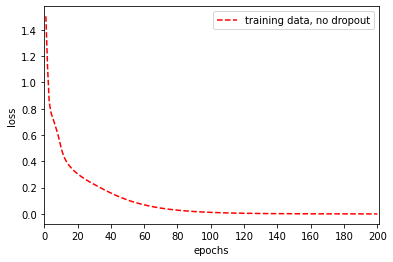

In [45]:
plt.plot(np.arange(1,(n_epochs+1),1), LOSS['training data no dropout'], 'r--')
plt.legend(['training data, no dropout', 'training data, dropout'])
plt.xlabel('epochs')
plt.xlim([0, (n_epochs+1)])
plt.xticks(np.arange(0,(n_epochs+1),20))
plt.ylabel('loss')
;

''

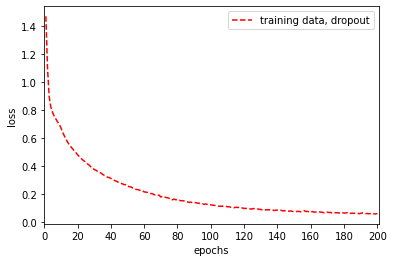

In [46]:
plt.plot(np.arange(1,(n_epochs+1),1), LOSS['training data dropout'], 'r--')
plt.legend(['training data, dropout'])
plt.xlabel('epochs')
plt.xlim([0, (n_epochs+1)])
plt.xticks(np.arange(0,(n_epochs+1),20))
plt.ylabel('loss')
;

In [25]:
z = model(x_val)
z_dropout = model_drop(x_val)

_,yhat=torch.max(z.data,1)
_,yhat_dropout=torch.max(z_dropout.data,1)

eval_matrix = (pd.crosstab(y_val, yhat))
eval_matrix_dropout = (pd.crosstab(y_val, yhat_dropout))

In [26]:
(eval_matrix[0][0]+eval_matrix[1][1]+eval_matrix[2][2])/y_val.shape[0]

0.4140127388535032

In [27]:
(eval_matrix_dropout[0][0]+eval_matrix_dropout[1][1]+eval_matrix_dropout[2][2])/y_val.shape[0]

0.3630573248407643

##### summary WITHOUT dropout

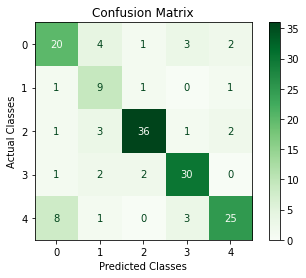

In [28]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [29]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['ACC'
                    ,'AGF'
                    ,'AGM'
                    ,'AUC'
                    ,'AUPR'
                    ,'BCD'
                    ,'BM'
                    ,'CEN'
                    ,'ERR'
                    ,'F0.5'
                    ,'F1'
                    ,'F2'
                    ,'FDR'
                    ,'FN'
                    ,'FNR'
                    ,'FOR'
                    ,'FP'
                    ,'FPR'
                    ,'G'
                    ,'GI'
                    ,'GM'
                    ,'IBA'
                    ,'ICSI'
                    ,'IS'
                    ,'J'
                    ,'LS'
                    ,'MCEN'
                    ,'N'
                    ,'NLR'
                    ,'NPV'
                    ,'OC'
                    ,'OOC'
                    ,'OP'
                    ,'P'
                    ,'PLR'
                    ,'POP'
                    ,'PPV'
                    ,'PRE'
                    ,'RACC'
                    ,'RACCU'
                    ,'TN'
                    ,'TNR'
                    ,'TON'
                    ,'TOP'
                    ,'TP'
                    ,'TPR'
                    ,'Y'
                    ,'dInd'
                    ,'sInd']]
cm_stats = cm_stats.T
cm_stats

,Stationary,Go-forward,Go-right,Go-backward,Go-left
Class,,,,,
ACC,0.86624,0.9172,0.92994,0.92357,0.89172
AGF,0.78021,0.8065,0.89575,0.89969,0.80186
AGM,0.83983,0.88144,0.92661,0.918,0.87125
AUC,0.79003,0.84052,0.90106,0.89988,0.817
AUPR,0.65591,0.61184,0.8686,0.83398,0.7545
BCD,0.00318,0.02229,0.00955,0.00637,0.02229
BM,0.58005,0.68103,0.80212,0.79977,0.63401
CEN,0.4688,0.53387,0.24647,0.28023,0.35009
ERR,0.13376,0.0828,0.07006,0.07643,0.10828


In [30]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()
inputs, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(inputs)
tb.add_image("images", grid)
tb.add_graph(model, x)
tb.close()

##### summary WITH dropout

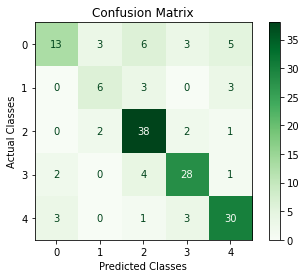

In [31]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat_dropout))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [32]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat_dropout))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['ACC'
                    ,'AGF'
                    ,'AGM'
                    ,'AUC'
                    ,'AUPR'
                    ,'BCD'
                    ,'BM'
                    ,'CEN'
                    ,'ERR'
                    ,'F0.5'
                    ,'F1'
                    ,'F2'
                    ,'FDR'
                    ,'FN'
                    ,'FNR'
                    ,'FOR'
                    ,'FP'
                    ,'FPR'
                    ,'G'
                    ,'GI'
                    ,'GM'
                    ,'IBA'
                    ,'ICSI'
                    ,'IS'
                    ,'J'
                    ,'LS'
                    ,'MCEN'
                    ,'N'
                    ,'NLR'
                    ,'NPV'
                    ,'OC'
                    ,'OOC'
                    ,'OP'
                    ,'P'
                    ,'PLR'
                    ,'POP'
                    ,'PPV'
                    ,'PRE'
                    ,'RACC'
                    ,'RACCU'
                    ,'TN'
                    ,'TNR'
                    ,'TON'
                    ,'TOP'
                    ,'TP'
                    ,'TPR'
                    ,'Y'
                    ,'dInd'
                    ,'sInd']]
cm_stats = cm_stats.T
cm_stats

,Stationary,Go-forward,Go-right,Go-backward,Go-left
Class,,,,,
ACC,0.85987,0.92994,0.87898,0.90446,0.89172
AGF,0.64859,0.69875,0.89118,0.86499,0.86389
AGM,0.78625,0.82478,0.87908,0.89514,0.88575
AUC,0.69698,0.73276,0.88046,0.86721,0.86374
AUPR,0.57778,0.52273,0.80725,0.78889,0.78041
BCD,0.03822,0.00318,0.02866,0.00318,0.00955
BM,0.39396,0.46552,0.76091,0.73443,0.72748
CEN,0.55198,0.48543,0.32478,0.3321,0.34918
ERR,0.14013,0.07006,0.12102,0.09554,0.10828


In [35]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()
inputs, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(inputs)
tb.add_image("images", grid)
tb.add_graph(model_drop, x)
tb.close()

#### 4 layer feed forward

In [47]:
new_column_names = pd.read_csv('skeleton_column_names.csv', header=None)[0].to_list()
new_labels = pd.read_csv('skeleton_labels.csv', header=None)[0].to_list()

df_skeleton = pd.read_csv('datasets/PedCut2013_SegmentationDataset/keypoints.json.udt.csv')
df_skeleton = df_skeleton[new_labels]
df_skeleton.columns = new_column_names
df_skeleton.dropna(inplace=True)

df_classification = pd.read_csv('datasets/PedCut2013_SegmentationDataset/classification.json.udt.csv')
df_classification = df_classification[['imageUrl', 'annotation']]
df_classification.dropna(inplace=True)
df_classification = pd.DataFrame(df_classification)
df_classification.columns = ['imageUrl', 'classification']

merged_df = df_skeleton.merge(df_classification, how = 'inner', on = ['imageUrl'])
new_column_names.pop(0)
df_skeleton = merged_df[new_column_names]

df_classification = merged_df['classification']
df_classification = pd.DataFrame(df_classification)

df_classification['simplified_classification'] = np.where(df_classification['classification'] == 'stationary', 0,\
    np.where(df_classification['classification'] == 'go-forward', 1,\
    np.where(df_classification['classification'] == 'go-right', 2,\
    np.where(df_classification['classification'] == 'go-backward', 3,\
    np.where(df_classification['classification'] == 'go-left', 4, np.nan)))))

y_actual = np.array(df_classification['simplified_classification'])

ncut = int(len(y_actual)*0.8)

y = y_actual[:ncut]
y_val = y_actual[ncut:]

x = np.array(df_skeleton[:ncut])
x_val = np.array(df_skeleton[ncut:])

x_train = x.reshape(-1, x.shape[1]).astype('float32')
y_train = y

x_val = x_val.reshape(-1, x_val.shape[1]).astype('float32')
y_val = y_val

x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

In [48]:
from torch.utils.data import Dataset, DataLoader
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(x).type(torch.FloatTensor)
        self.y=torch.from_numpy(y).type(torch.LongTensor)
        self.len=self.x.shape[0]
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len

data_set=Data()
trainloader=DataLoader(dataset=data_set,batch_size=10)

In [64]:
class Net(nn.Module):
    def __init__(self,in_size,n_hidden1,n_hidden2,out_size,p=0):

        super(Net, self).__init__()
        self.drop=nn.Dropout(p=p)
        self.linear1=nn.Linear(in_size,n_hidden1)
        # nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear2=nn.Linear(n_hidden1,n_hidden2)
        # nn.init.kaiming_uniform_(self.linear1.weight,nonlinearity='relu')
        self.linear3=nn.Linear(n_hidden2,n_hidden2)
        # nn.init.kaiming_uniform_(self.linear3.weight,nonlinearity='relu')
        self.linear4=nn.Linear(n_hidden2,out_size)

    def forward(self, x):
        x=F.relu(self.linear1(x))
        x=self.drop(x)
        x=F.relu(self.linear2(x))
        x=self.drop(x)
        x=F.relu(self.linear3(x))
        x=self.drop(x)
        x=self.linear4(x)
        # return F.log_softmax(x, dim=1)
        return x

model = Net(34, 68, 68, 5)
model_drop = Net(34, 68, 68, 5, p=0.2)

optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

LOSS={}
LOSS['training data no dropout']=[]
LOSS['validation data no dropout']=[]
LOSS['training data dropout']=[]
LOSS['validation data dropout']=[]

In [51]:
n_epochs=200

for epoch in range(1, n_epochs+1):
    model = model.float()
    model_drop = model_drop.float()
    # TRAINING
    loss_value = 0.0
    loss_drop_value = 0.0
    for x, y in trainloader:
        #train mode
        model.train()
        model_drop.train()
        #clear gradient
        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        #make a prediction for both models
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        #calculate the lossf or both models
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)
        #accumulate loss for further analysis for both models
        loss_value += loss.item()
        loss_drop_value += loss_drop.item()
        #Backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        loss_drop.backward()
        #the step function on an Optimizer makes an update to its parameters
        optimizer_ofit.step()
        optimizer_drop.step()
        #store the loss for the training data for both models
    loss_value = loss_value / len(trainloader)
    loss_drop_value = loss_drop_value / len(trainloader)

    LOSS['training data no dropout'].append(loss_value)
    LOSS['training data dropout'].append(loss_drop_value)
    print('epoch {}, train loss {}'.format(epoch, loss_value))
    print('epoch {}, train loss {}'.format(epoch, loss_drop_value))

    # # VALIDATION
    # with torch.no_grad():
    #     for x, y in trainloader:
    #         model_drop.eval()
    #         model_drop.train()
    #         #make a prediction for both models
    #         yhat = model(data_set.x)
    #         yhat_drop = model_drop(data_set.x)
    #         #calculate the lossf or both models
    #         loss = criterion(yhat, data_set.y)
    #         loss_drop = criterion(yhat_drop, data_set.y)
    #         #store the loss for the validation data for both models
    #         LOSS['validation data no dropout'].append(loss.item())
    #         LOSS['validation data dropout'].append(loss_drop.item())
    #         print('epoch {}, test loss {}'.format(epoch, loss.item()))

epoch 1, train loss 1.4551018590018863
epoch 1, train loss 1.4665522915976388
epoch 2, train loss 0.9389415430644202
epoch 2, train loss 0.9623466578740922
epoch 3, train loss 0.7575892351922535
epoch 3, train loss 0.8175610918847341
epoch 4, train loss 0.7030710142756266
epoch 4, train loss 0.7686502886196923
epoch 5, train loss 0.6619656842852396
epoch 5, train loss 0.7215892587389264
epoch 6, train loss 0.6085104516574315
epoch 6, train loss 0.6704807905923753
epoch 7, train loss 0.5268506965939961
epoch 7, train loss 0.6259837519554865
epoch 8, train loss 0.46281101117058404
epoch 8, train loss 0.5942721745324513
epoch 9, train loss 0.42672769938196453
epoch 9, train loss 0.5657312453739227
epoch 10, train loss 0.4024517933527629
epoch 10, train loss 0.5455815565018427
epoch 11, train loss 0.38359694963409785
epoch 11, train loss 0.5222320258617401
epoch 12, train loss 0.3676103362961421
epoch 12, train loss 0.5035313703711071
epoch 13, train loss 0.3538451109613691
epoch 13, train

''

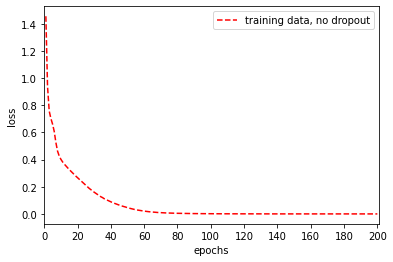

In [52]:
plt.plot(np.arange(1,(n_epochs+1),1), LOSS['training data no dropout'], 'r--')
plt.legend(['training data, no dropout', 'training data, dropout'])
plt.xlabel('epochs')
plt.xlim([0, (n_epochs+1)])
plt.xticks(np.arange(0,(n_epochs+1),20))
plt.ylabel('loss')
;

''

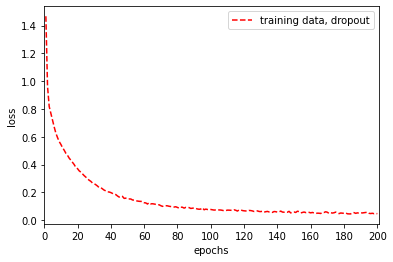

In [53]:
plt.plot(np.arange(1,(n_epochs+1),1), LOSS['training data dropout'], 'r--')
plt.legend(['training data, dropout'])
plt.xlabel('epochs')
plt.xlim([0, (n_epochs+1)])
plt.xticks(np.arange(0,(n_epochs+1),20))
plt.ylabel('loss')
;

In [54]:
z = model(x_val)
z_dropout = model_drop(x_val)

_,yhat=torch.max(z.data,1)
_,yhat_dropout=torch.max(z_dropout.data,1)

eval_matrix = (pd.crosstab(y_val, yhat))
eval_matrix_dropout = (pd.crosstab(y_val, yhat_dropout))

In [55]:
(eval_matrix[0][0]+eval_matrix[1][1]+eval_matrix[2][2])/y_val.shape[0]

0.3503184713375796

In [56]:
(eval_matrix_dropout[0][0]+eval_matrix_dropout[1][1]+eval_matrix_dropout[2][2])/y_val.shape[0]

0.3885350318471338

##### summary WITHOUT dropout

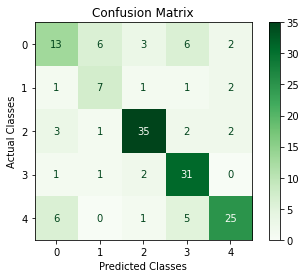

In [57]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [58]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['ACC'
                    ,'AGF'
                    ,'AGM'
                    ,'AUC'
                    ,'AUPR'
                    ,'BCD'
                    ,'BM'
                    ,'CEN'
                    ,'ERR'
                    ,'F0.5'
                    ,'F1'
                    ,'F2'
                    ,'FDR'
                    ,'FN'
                    ,'FNR'
                    ,'FOR'
                    ,'FP'
                    ,'FPR'
                    ,'G'
                    ,'GI'
                    ,'GM'
                    ,'IBA'
                    ,'ICSI'
                    ,'IS'
                    ,'J'
                    ,'LS'
                    ,'MCEN'
                    ,'N'
                    ,'NLR'
                    ,'NPV'
                    ,'OC'
                    ,'OOC'
                    ,'OP'
                    ,'P'
                    ,'PLR'
                    ,'POP'
                    ,'PPV'
                    ,'PRE'
                    ,'RACC'
                    ,'RACCU'
                    ,'TN'
                    ,'TNR'
                    ,'TON'
                    ,'TOP'
                    ,'TP'
                    ,'TPR'
                    ,'Y'
                    ,'dInd'
                    ,'sInd']]
cm_stats = cm_stats.T
cm_stats

,Stationary,Go-forward,Go-right,Go-backward,Go-left
Class,,,,,
ACC,0.82166,0.9172,0.90446,0.88535,0.88535
AGF,0.6303,0.73057,0.87304,0.89092,0.79868
AGM,0.75624,0.83959,0.90121,0.88538,0.86565
AUC,0.67336,0.76408,0.87627,0.88548,0.81284
AUPR,0.4875,0.525,0.82364,0.7873,0.74106
BCD,0.01911,0.00955,0.00318,0.03185,0.01911
BM,0.34672,0.52816,0.75255,0.77096,0.62568
CEN,0.63641,0.54696,0.3162,0.34448,0.37478
ERR,0.17834,0.0828,0.09554,0.11465,0.11465


In [59]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()
inputs, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(inputs)
tb.add_image("images", grid)
tb.add_graph(model, x)
tb.close()

##### summary WITH dropout

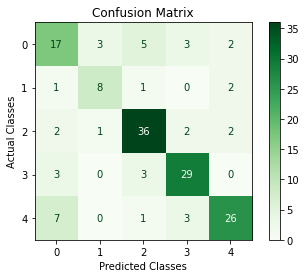

In [60]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat_dropout))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm.plot(cmap=plt.cm.Greens,number_label=True,plot_lib="matplotlib");

In [61]:
cm = ConfusionMatrix(actual_vector=np.array(y_val).astype(int), predict_vector=np.array(yhat_dropout))

name = "cm"
cm.save_csv(name=name)
name += ".csv"
cm_stats = pd.read_csv(name, index_col='Class')
cm_stats = cm_stats.rename(columns={'0': 'Stationary', '1': 'Go-forward', '2': 'Go-right', '3': 'Go-backward', '4': 'Go-left'})
cm_stats = cm_stats.T
cm_stats = cm_stats[['ACC'
                    ,'AGF'
                    ,'AGM'
                    ,'AUC'
                    ,'AUPR'
                    ,'BCD'
                    ,'BM'
                    ,'CEN'
                    ,'ERR'
                    ,'F0.5'
                    ,'F1'
                    ,'F2'
                    ,'FDR'
                    ,'FN'
                    ,'FNR'
                    ,'FOR'
                    ,'FP'
                    ,'FPR'
                    ,'G'
                    ,'GI'
                    ,'GM'
                    ,'IBA'
                    ,'ICSI'
                    ,'IS'
                    ,'J'
                    ,'LS'
                    ,'MCEN'
                    ,'N'
                    ,'NLR'
                    ,'NPV'
                    ,'OC'
                    ,'OOC'
                    ,'OP'
                    ,'P'
                    ,'PLR'
                    ,'POP'
                    ,'PPV'
                    ,'PRE'
                    ,'RACC'
                    ,'RACCU'
                    ,'TN'
                    ,'TNR'
                    ,'TON'
                    ,'TOP'
                    ,'TP'
                    ,'TPR'
                    ,'Y'
                    ,'dInd'
                    ,'sInd']]
cm_stats = cm_stats.T
cm_stats

,Stationary,Go-forward,Go-right,Go-backward,Go-left
Class,,,,,
ACC,0.83439,0.94904,0.89172,0.91083,0.89172
AGF,0.71321,0.80516,0.87719,0.88072,0.81485
AGM,0.79568,0.88546,0.89007,0.90375,0.87464
AUC,0.73215,0.81954,0.87475,0.8815,0.82635
AUPR,0.56667,0.66667,0.80991,0.80618,0.7576
BCD,0.0,0.0,0.00955,0.00637,0.01592
BM,0.4643,0.63908,0.74949,0.763,0.6527
CEN,0.57807,0.41562,0.32855,0.30259,0.35478
ERR,0.16561,0.05096,0.10828,0.08917,0.10828


In [63]:
import torchvision
from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()
inputs, labels = next(iter(trainloader))
grid = torchvision.utils.make_grid(inputs)
tb.add_image("images", grid)
tb.add_graph(model_drop, x)
tb.close()